# RF Classifier with Wrapper-Based FS

Steven Sison | March 9, 2024

## Description

This document will be used to train a model using the reduced feature set obtain by using the wrapper-based method, forward feature selection. The model will be evaluated in terms of the usual metrics (accuracy, precision, F1-score, recall) as well as the training time. The model will also be stored for future evaluation purposes.

## Training the Model

### Preliminaries

#### 1. Loading the Dataset

In [5]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime
import joblib
import os

print(os.getcwd())

dataset = pd.read_csv("../../02_feature-engineering/final-datasets/final_unbalanced_withLexical.csv")      # Loading the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)

c:\Users\sison\OneDrive - University of the Philippines\04_Senior-Year_23-24\02_Acad-Files\01_EEE\01_EEE-196_199\00_Actual-Repo\SecURL\05_integration-model-fs\rf


#### 2. Preprocessing (Balancing)

In [6]:
dataset['url_type'].value_counts()

url_type
0    428080
2    134094
1     95308
3     26700
Name: count, dtype: int64

In [7]:
# Upsampling

from sklearn.utils import resample

dataset_benign = dataset[(dataset['url_type'] == 0)]
dataset_defacement = dataset[(dataset['url_type'] == 1)]
dataset_phishing = dataset[(dataset['url_type'] == 2)]
dataset_malware = dataset[(dataset['url_type'] == 3)]

dataset_defacement_upsampled = resample(dataset_defacement,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_phishing_upsampled = resample(dataset_phishing,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_malware_upsampled = resample(dataset_malware,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_benign_upsampled = resample(dataset_benign,
                                        replace=True,
                                        n_samples = dataset_benign.shape[0],
                                        random_state = 15)

dataset_upsampled = pd.concat([dataset_benign_upsampled, dataset_defacement_upsampled, dataset_malware_upsampled, dataset_phishing_upsampled])

# dataset_upsampled.info(0)
dataset_upsampled['url_type'].value_counts()

X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(dataset_upsampled.drop(columns=['url_type']), dataset_upsampled['url_type'], test_size = 0.2, random_state=42)

#### 3. Removing Unnecessary Features

In [8]:
important_features_wrapper_12 = ['url_domain_entropy', 'url_number_of_digits', 'url_path_length', 'url_host_length', 'get_tld', 'url_num_subdomain', 'url_number_of_letters', 'url_num_periods', 'url_num_forward_slash', 'has_login_in_string', 'has_php_in_string', 'url_scheme']
important_features_wrapper_33 = ['url_length',
 'url_domain_entropy',
 'url_is_digits_in_domain',
 'url_number_of_parameters',
 'url_number_of_digits',
 'url_string_entropy',
 'url_path_length',
 'url_host_length',
 'get_tld',
 'url_domain_len',
 'url_num_subdomain',
 'url_number_of_fragments',
 'url_is_encoded',
 'url_number_of_letters',
 'url_num_periods',
 'url_num_of_hyphens',
 'url_num_underscore',
 'url_num_forward_slash',
 'url_num_semicolon',
 'url_num_mod_sign',
 'has_login_in_string',
 'has_signin_in_string',
 'has_logon_in_string',
 'has_loginasp_in_string',
 'has_exe_in_string',
 'has_viewerphp_in_string',
 'has_getImageasp_in_string',
 'has_paypal_in_string',
 'has_dbsysphp_in_string',
 'has_shopping_in_string',
 'has_php_in_string',
 'has_bin_in_string',
 'has_personal_in_string',
 'url_scheme']

X_up_test_12 = X_up_test[important_features_wrapper_12]
X_up_train_12 = X_up_train[important_features_wrapper_12]

X_up_test_33 = X_up_test[important_features_wrapper_33]
X_up_train_33 = X_up_train[important_features_wrapper_33]

X_up_test_33.head()

,url_length,url_domain_entropy,url_is_digits_in_domain,url_number_of_parameters,url_number_of_digits,url_string_entropy,url_path_length,url_host_length,get_tld,url_domain_len,...,has_exe_in_string,has_viewerphp_in_string,has_getImageasp_in_string,has_paypal_in_string,has_dbsysphp_in_string,has_shopping_in_string,has_php_in_string,has_bin_in_string,has_personal_in_string,url_scheme
14155,19,2.584963,0,0,0,3.642150,19,0,0,6,...,0,0,0,0,0,0,0,0,0,0
617208,26,2.321928,0,0,0,3.767183,26,0,0,5,...,0,0,0,0,0,0,0,0,0,0
43783,25,1.500000,0,0,0,3.763856,25,0,0,4,...,0,0,0,0,0,0,0,0,0,0
543456,52,3.762267,0,0,6,4.190260,18,27,320,23,...,0,0,0,0,0,0,0,0,0,27
527953,70,2.521641,0,0,10,4.459371,49,14,276,7,...,0,0,0,0,0,0,0,0,0,27


#### Model Training

In [9]:
from sklearn.model_selection import KFold

# Initialize CV
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# Set Hyperparameters
params_gbm = {}
params_gbm['max_depth'] = round(20)
params_gbm['min_samples_leaf'] = 1
params_gbm['min_samples_split'] = round(100)
params_gbm['n_estimators'] = round(720.4)

# Initialize the model
xgb_classifier_12 = Pipeline([
    ('classifier', RandomForestClassifier(random_state=123, **params_gbm))
])
xgb_classifier_33 = Pipeline([
    ('classifier', RandomForestClassifier(random_state=123, **params_gbm))
])

# Train the Model
xgb_classifier_12.fit(X_up_train_12, y_up_train)
y_up_pred_12 = xgb_classifier_12.predict(X_up_test_12)

xgb_classifier_33.fit(X_up_train_33, y_up_train)
y_up_pred_33 = xgb_classifier_33.predict(X_up_test_33)

#### Evaluation

In [10]:
# Classification Report
print(classification_report(y_up_test, y_up_pred_12))
print(classification_report(y_up_test, y_up_pred_33))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     85144
           1       0.95      1.00      0.97     85582
           2       0.91      0.90      0.90     85715
           3       0.99      0.94      0.97     86023

    accuracy                           0.94    342464
   macro avg       0.95      0.94      0.94    342464
weighted avg       0.95      0.94      0.94    342464

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     85144
           1       0.95      1.00      0.97     85582
           2       0.91      0.90      0.90     85715
           3       1.00      0.95      0.97     86023

    accuracy                           0.95    342464
   macro avg       0.95      0.95      0.95    342464
weighted avg       0.95      0.95      0.95    342464



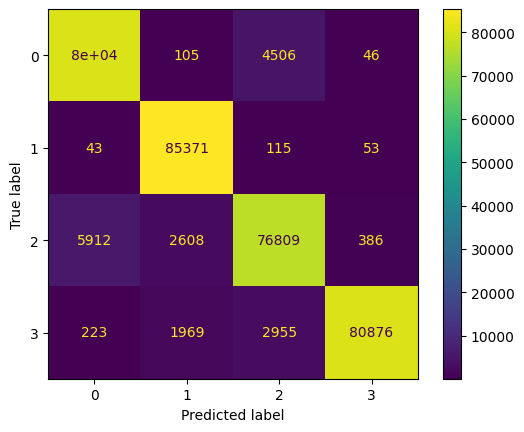

In [11]:
# Confusion Matrix for 12 Features
cm_up = confusion_matrix(y_up_test, y_up_pred_12, labels=xgb_classifier_12.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = xgb_classifier_12.classes_)
disp.plot()
plt.show()

In [8]:
# Cross Validation Score
scores = cross_val_score(XGBClassifier(random_state=45, **params_gbm),
                        X_up_train, y_up_train, scoring='accuracy', cv=cv).mean()

print(scores)

0.9317767699682437


In [12]:
# Dumping the model
joblib.dump(xgb_classifier_12, 'rf_ffs_12.sav')
joblib.dump(xgb_classifier_33, 'rf_ffs_33.sav')

['rf_ffs_33.sav']

In [10]:
print(os.getcwd())

c:\Users\sison\OneDrive - University of the Philippines\04_Senior-Year_23-24\02_Acad-Files\01_EEE\01_EEE-196_199\00_Actual-Repo\SecURL\05_integration-model-fs\xgb


In [15]:
import lexical_generator_12
import lexical_generator_33
import time

def xgb_predict_maliciousness_12(url):

    numerical_values = lexical_generator_12.lexical_generator(url)

    match xgb_classifier_12.predict(numerical_values):
        case 0:
            return "Benign"
        case 1:
            return "Defacement"
        case 2:
            return "Phishing"
        case 3:
            return "Malware"
        
def xgb_predict_maliciousness_33(url):

    numerical_values = lexical_generator_33.lexical_generator(url)

    numerical_values.head()

    match xgb_classifier_33.predict(numerical_values):
        case 0:
            return "Benign"
        case 1:
            return "Defacement"
        case 2:
            return "Phishing"
        case 3:
            return "Malware"

url = "facebook.com"
print("Current URL: "+url)

start = time.perf_counter()
prediction = xgb_predict_maliciousness_12(url)
end = time.perf_counter()
print("------- 12 Features -------------")
print(prediction)
print(end-start)

start = time.perf_counter()
prediction = xgb_predict_maliciousness_33(url)
end = time.perf_counter()
print("------- 33 Features -------------")
print(prediction)
print(end-start)

Current URL: facebook.com
------- 12 Features -------------
Phishing
0.18042889999924228
------- 33 Features -------------
Phishing
0.11801500001456589
